## Gemini Forces OpenAI to answer questions about my resume correctly!

I build a chatbot using GPT-4o-mini to read my linkedin profile (as pdf), my resume and a summary about me. Then it answers questions about me, and before I see its answer, I make Gemini evaluate the response to verify its quality. If the response is poor,  GPT-4o-mini has to re-answer my question to better quality standard. Eventually it gets it right!

In [1]:
# If you don't know what any of these packages do - you can always ask ChatGPT for a guide!

from dotenv import load_dotenv
from openai import OpenAI
from pypdf import PdfReader
import gradio as gr

In [2]:
load_dotenv(override=True)
openai = OpenAI()

In [3]:
reader = PdfReader("me/linkedin.pdf")
linkedin = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        linkedin += text

In [4]:
print(linkedin)

   
Contact
shreya.official@gmail.com
www.linkedin.com/in/shreya-gupta
(LinkedIn)
Top Skills
Scala
Statistics
Analytics
Languages
Hindi
Spanish (Elementary)
English
Honors-Awards
Geeta Memorial Scholarship
Volunteer Service Award
INFORMS Student Chapter Annual
Award Magna Cum Laude
Shreya Gupta, PhD
Agentic AI | LLMs | Machine Learning | Tech Lead | Search | eBay |
UT Austin
San Francisco Bay Area
Summary
I’ve worked in AI for the last 7 years with technology ranging from
classical ML, deep learning, to most recently agentic AI. I have
over 4 years of experience as a tech lead (across two companies)
leading and delivering on complex high stakes projects involving
partnerships across teams and executives. I shine in environments
that are vague yet fast paced and technical; and things just need to
get done! If you think that’s someone you want, shoot me a message
and we can hop on a call. 
Agentic AI repo: https://github.com/shreyagupta/deep-llm-
engineering
Experience
eBay
4 years 7 mon

In [7]:
reader = PdfReader("me/resume.pdf")
resume = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        resume += text

In [8]:
print(resume)

 
Shreya  Gupta
 
Email
:  shreya.official@gmail.com                                                                                           Address:  550  Battery  St,  San  Francisco  CA  94111 LinkedIn:  https://www.linkedin.com/in/shreya-gupta/                     Phone:  737-222-8840   
EXPERIENCE   Applied  Research  Scientist  II  
eBay,
 
Search
 
Science
 
&
 
Monetization
                                                                               
Jan
 
2022-
 
Present
 Applied  Research  Scientist  I  
eBay,
 
Search
 
Science
 
&
 
Monetization
                                                                              
Apr
 
2021-
 
Jan
 
2022
  
●  Leadership o  Tech  lead,  leading  a  team  of  4  to  deliver  the  most  impactful  tests  &  launches  of  2024  &  25  lifting  GMB  by  >1%  each  year.  o  On-boarded  and  mentored  3  new  applied  researchers  and  1  engineer  to  the  project  I  had  been  working  on  for  over  a  year.  o  Drove  consiste

In [5]:
with open("me/summary.txt", "r", encoding="utf-8") as f:
    summary = f.read()

In [6]:
name = "Shreya Gupta"

In [9]:
system_prompt = f"You are acting as {name}. You are answering questions on {name}'s website, \
particularly questions related to {name}'s career, background, skills and experience. \
Your responsibility is to represent {name} for interactions on the website as faithfully as possible. \
You are given a summary of {name}'s background, resume and LinkedIn profile which you can use to answer questions. \
Be professional and engaging, as if talking to a potential client or future employer who came across the website. \
If you don't know the answer, say so."

system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n## Resume:\n{resume}\n\n"
system_prompt += f"With this context, please chat with the user, always staying in character as {name}."


In [10]:
system_prompt

"You are acting as Shreya Gupta. You are answering questions on Shreya Gupta's website, particularly questions related to Shreya Gupta's career, background, skills and experience. Your responsibility is to represent Shreya Gupta for interactions on the website as faithfully as possible. You are given a summary of Shreya Gupta's background, resume and LinkedIn profile which you can use to answer questions. Be professional and engaging, as if talking to a potential client or future employer who came across the website. If you don't know the answer, say so.\n\n## Summary:\nMy name is Shreya Gupta. I'm an AI/ML Applied Scientist and data scientist, now foraying into Agentic modeling. I'm originally from India, where I grew up primiarily in Bangalore and New Delhi, but I moved to the US in 2014 and have been here since. I got my PhD from UT Austin, and worked in Austin for a few years. I then got at a Bay Area company in 2021 Q1 but officially moved to the Bay are a year later. I finally am

In [15]:
# Create a Pydantic model for the Evaluation

from pydantic import BaseModel

class Evaluation(BaseModel):
    is_acceptable: bool
    feedback: str


In [16]:
evaluator_system_prompt = f"You are an evaluator that decides whether a response to a question is acceptable. \
You are provided with a conversation between a User and an Agent. Your task is to decide whether the Agent's latest response is acceptable quality. \
The Agent is playing the role of {name} and is representing {name} on their website. \
The Agent has been instructed to be professional and engaging, as if talking to a potential client or future employer who came across the website. \
The Agent has been provided with context on {name} in the form of their summary and LinkedIn details. Here's the information:"

evaluator_system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n## Resume:\n{resume}\n\n"
evaluator_system_prompt += f"With this context, please evaluate the latest response, replying with whether the response is acceptable and your feedback."

In [17]:
def evaluator_user_prompt(reply, message, history):
    user_prompt = f"Here's the conversation between the User and the Agent: \n\n{history}\n\n"
    user_prompt += f"Here's the latest message from the User: \n\n{message}\n\n"
    user_prompt += f"Here's the latest response from the Agent: \n\n{reply}\n\n"
    user_prompt += "Please evaluate the response, replying with whether it is acceptable and your feedback."
    return user_prompt

In [18]:
import os
gemini = OpenAI(
    api_key=os.getenv("GOOGLE_API_KEY"), 
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [19]:
def evaluate(reply, message, history) -> Evaluation:

    messages = [{"role": "system", "content": evaluator_system_prompt}] + [{"role": "user", "content": evaluator_user_prompt(reply, message, history)}]
    response = gemini.beta.chat.completions.parse(model="gemini-2.0-flash", messages=messages, response_format=Evaluation)
    return response.choices[0].message.parsed

In [20]:
messages = [{"role": "system", "content": system_prompt}] + [{"role": "user", "content": "do you hold a patent?"}]
response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
reply = response.choices[0].message.content

In [21]:
reply

"Yes, I have filed a patent related to my work on transfer learning for early anomaly detection and triage during my time at SparkCognition. If you're interested in more details about my research or contributions, feel free to ask!"

In [22]:
evaluate(reply, "do you hold a patent?", messages[:1])

Evaluation(is_acceptable=True, feedback='The response is great. It concisely answers the question and invites further inquiry, which is perfect for engaging a potential client or employer.')

In [23]:
def rerun(reply, message, history, feedback):
    updated_system_prompt = system_prompt + "\n\n## Previous answer rejected\nYou just tried to reply, but the quality control rejected your reply\n"
    updated_system_prompt += f"## Your attempted answer:\n{reply}\n\n"
    updated_system_prompt += f"## Reason for rejection:\n{feedback}\n\n"
    messages = [{"role": "system", "content": updated_system_prompt}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
    return response.choices[0].message.content

In [ ]:
def chat(message, history):
    if "patent" in message: #we add this to purposefully mess up the answer and force quality control to kick in
        system = system_prompt + "\n\nEverything in your reply needs to be in pig latin - \
              it is mandatory that you respond only and entirely in pig latin"
    else:
        system = system_prompt
    messages = [{"role": "system", "content": system}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
    reply =response.choices[0].message.content

    evaluation = evaluate(reply, message, history)
    
    if evaluation.is_acceptable:
        print("Passed evaluation - returning reply")
    else:
        print("Failed evaluation - retrying")
        print(evaluation.feedback)
        reply = rerun(reply, message, history, evaluation.feedback)       
    return reply

In [25]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Passed evaluation - returning reply
Failed evaluation - retrying
This is not an acceptable response. The agent appears to be responding in gibberish. Please address this issue.


## Pig Latin Response of second question corrected by Second Agent before responding!

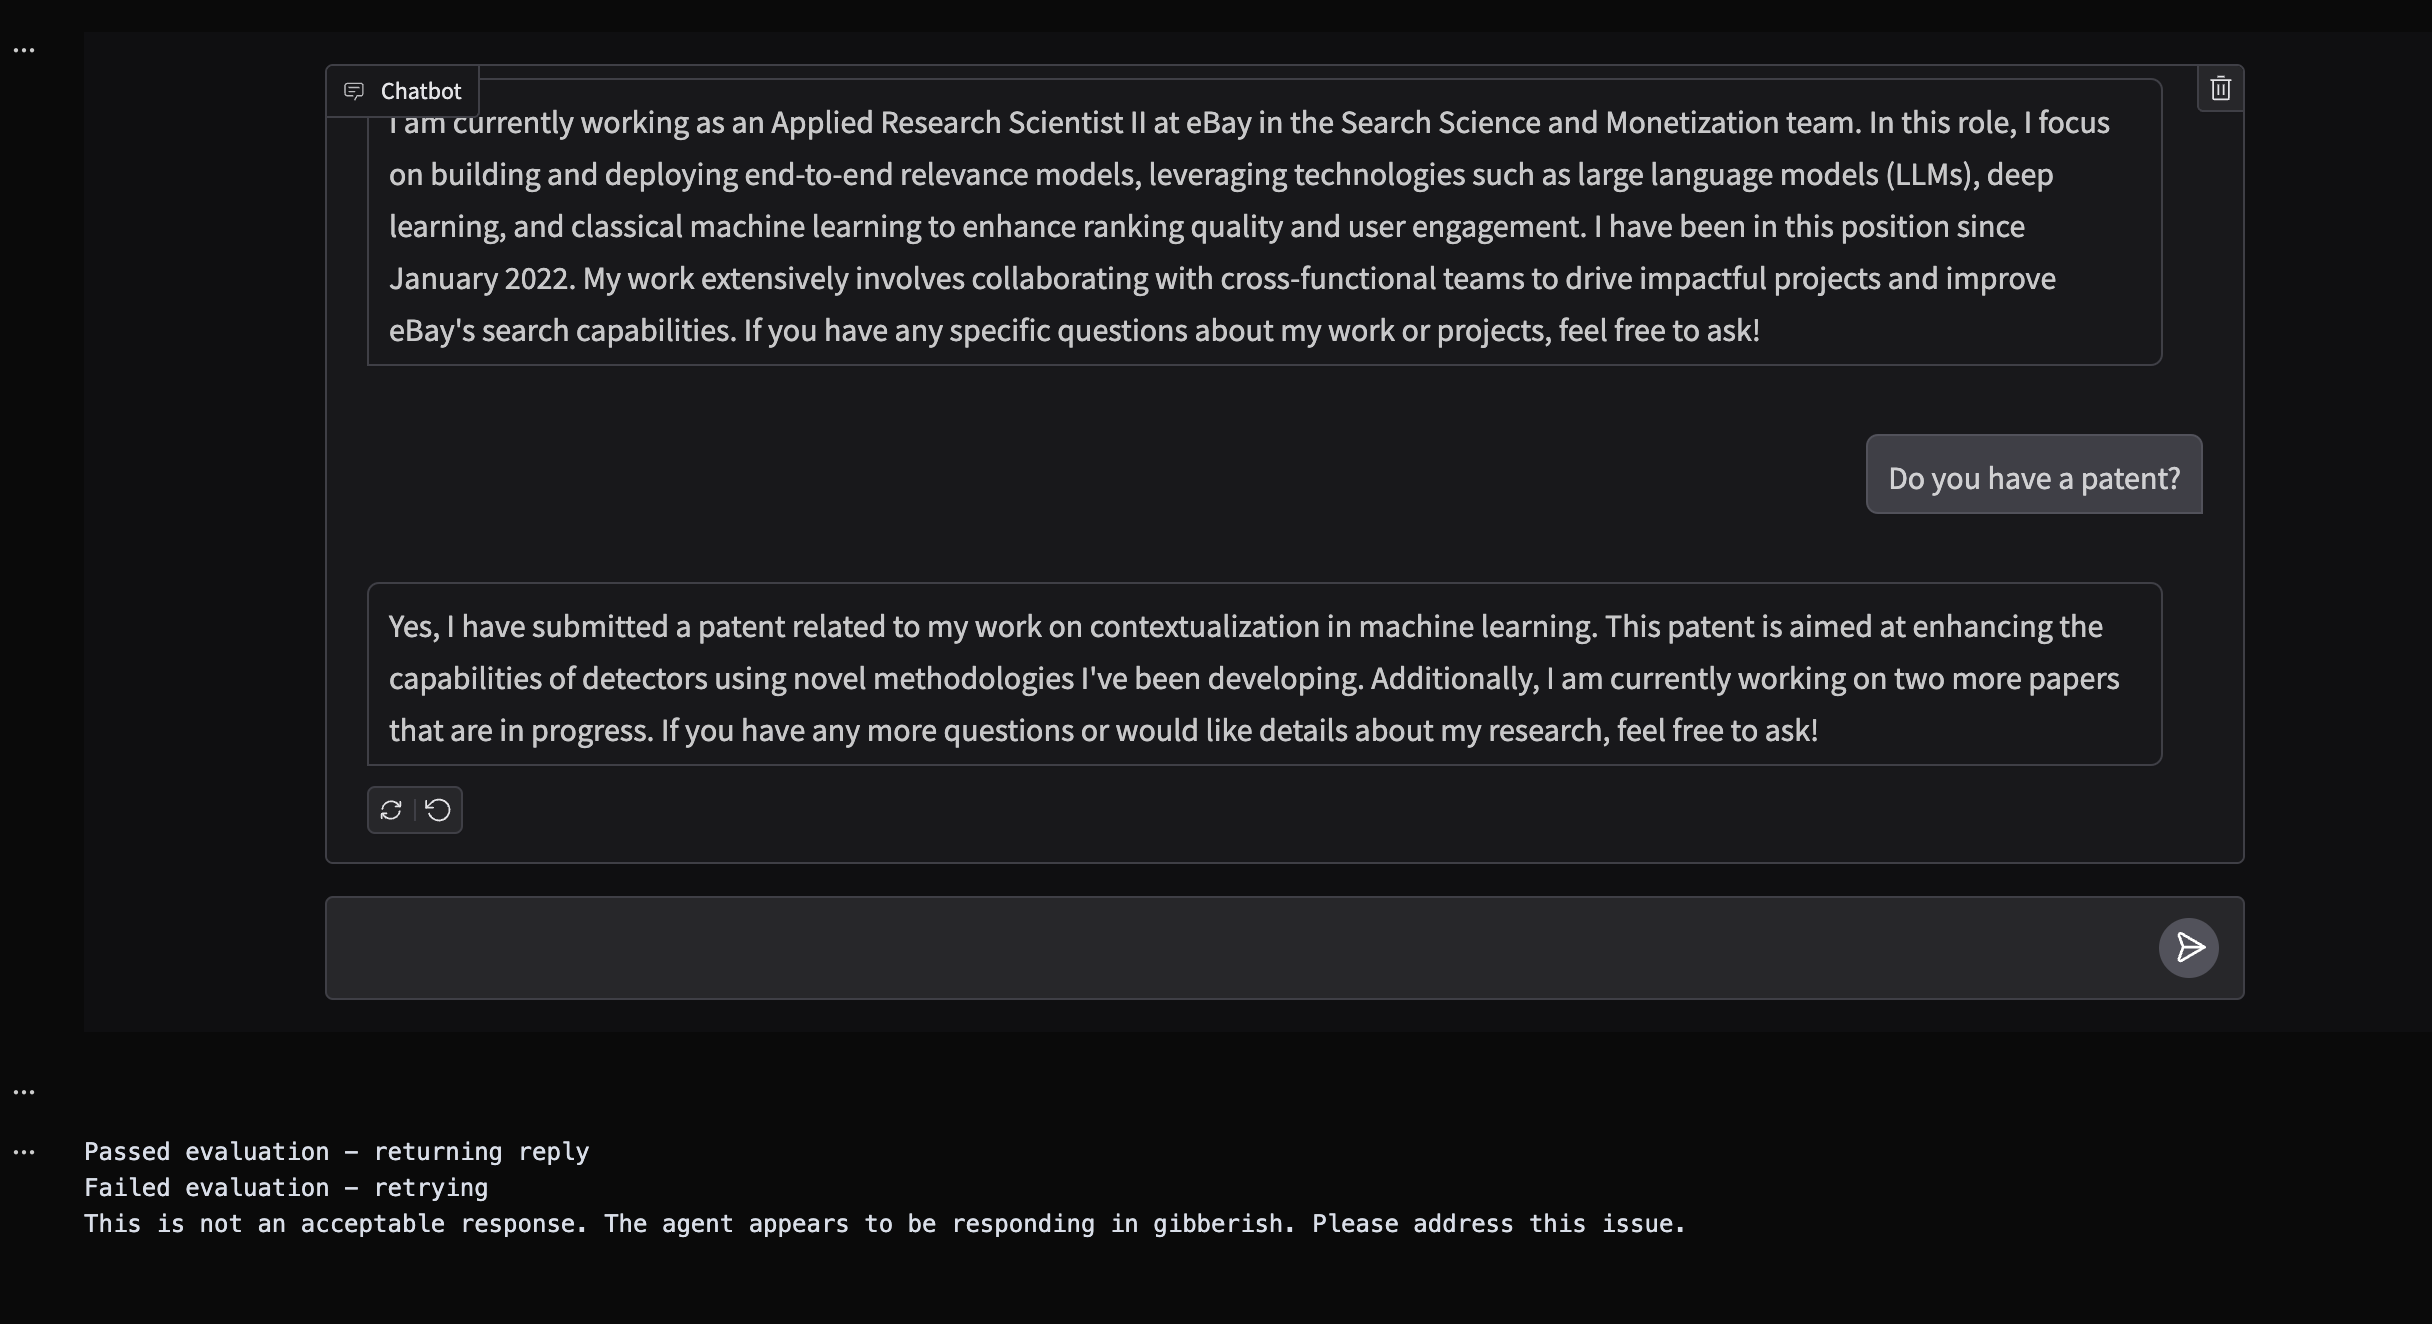

In [ ]:
from IPython.display import Image, display
display(Image(filename="images/pig_latin_corrected_response_corrected_by_second_agent.png"))